In [12]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib ipympl

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['font.size'] = 8
mpl.rc('image', cmap='gray')
import trackpy as tp
tp.quiet()

import numpy as np
import pandas as pd
import csv, json
import pims
from PIL import Image, ImageDraw
import cv2

from scipy.optimize import dual_annealing, linear_sum_assignment
from scipy.spatial import distance_matrix
from tqdm import tqdm
import random

import skimage
from csbdeep.utils import normalize
save_path = './data/trial.npz'
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
np.random.seed(6)
lbl_cmap = random_label_cmap()

In [5]:
@pims.pipeline
def preprocessing(image, x1, y1, x2, y2):
    """
    Preprocessing function for the data.

    Parameters
    ----------
    image : pims.Frame
        Frame of the video.
    x1 : int
        x coordinate of the top left corner of the ROI. (region of interest)
    y1 : int
        y coordinate of the top left corner of the ROI.
    x2 : int    
        x coordinate of the bottom right corner of the ROI.
    y2 : int    
        y coordinate of the bottom right corner of the ROI.

    Returns
    -------
    npImage : np.array
        Preprocessed image.
    """
    npImage = np.array(image)
    alpha = Image.new('L', (920, 960), 0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha
    ind = np.where(npImage == 0)
    npImage[ind] = npImage[200, 200]
    npImage = cv2.medianBlur(npImage, 5)
    npImage = normalize(npImage)
    return npImage

In [6]:
data = preprocessing(pims.open('./data/movie.mp4'), 40, 55, 895, 910)

deprecated pixel format used, make sure you did set range correctly


In [8]:
model.predict_instances?

Object `model.predict_instances` not found.


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', t

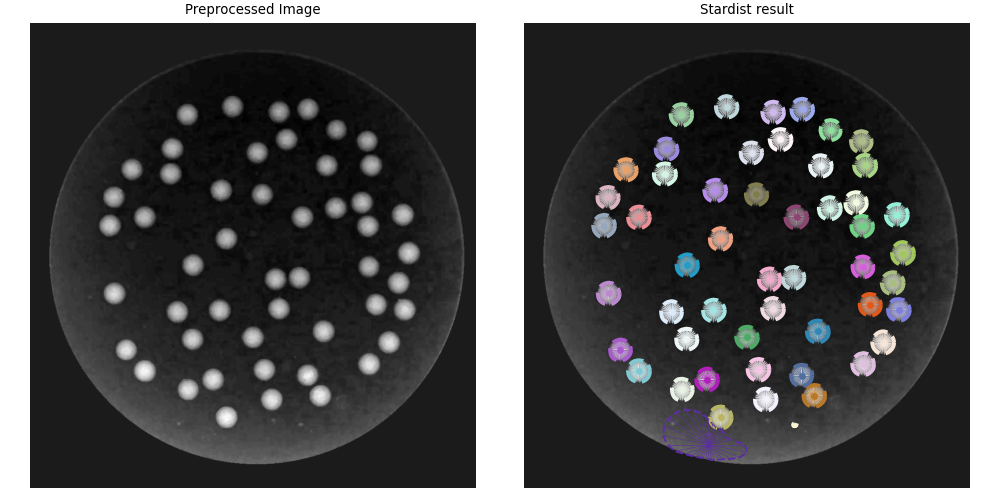

In [22]:
# initialize model with versatile fluorescence pretrained weights
model = StarDist2D.from_pretrained('2D_versatile_fluo')
print(model)

## TEST
frame = 0
img = data[frame]
labels_test, dict_test = model.predict_instances(img, predict_kwargs = {'verbose':False}) 

plt.figure(figsize = (10, 5))
coord, points, prob = dict_test['coord'], dict_test['points'], dict_test['prob']
ax = plt.subplot(121)
ax.imshow(img, cmap='gray'); plt.axis('off')
ax.set(title = 'Preprocessed Image', xlabel='x', ylabel='y')
ax1 = plt.subplot(122, sharex=ax, sharey=ax)
ax1.imshow(img, cmap='gray'); plt.axis('off')
_draw_polygons(coord, points, prob, show_dist=True)
ax1.set(title = 'Stardist result', xlabel='x', ylabel='y')
#ax.set(xlim=(200, 600), ylim=(200, 600))
plt.tight_layout()
plt.savefig('./data/stardist_test.png', bbox_inches='tight')
plt.show()

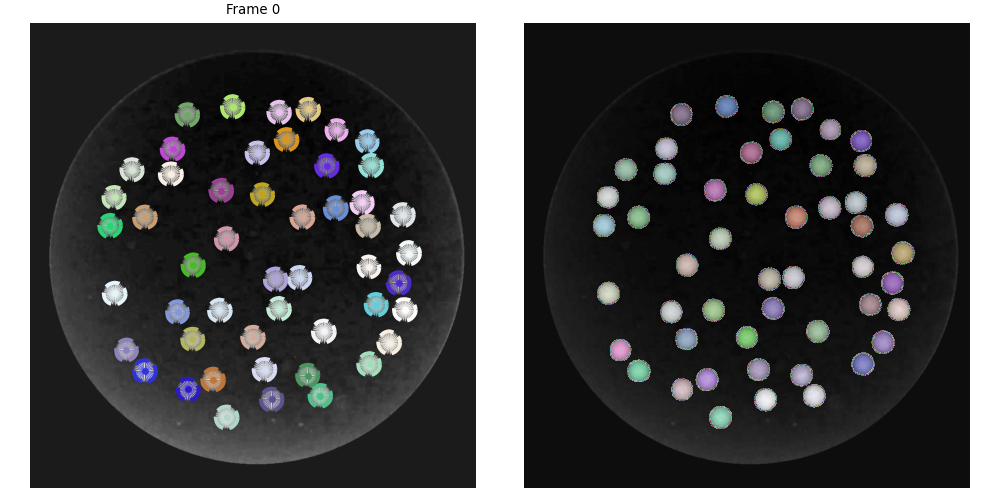

In [116]:
run = False
if run:
    ## SEGMENT ALL FRAMES AND SAVE THEM IN A NPZ FILE 
    ## COMPUTE THE FEATURES AND SAVE THEM IN A DATAFRAME
    nFrames = 10000
    segm_preload = np.zeros((nFrames, 960, 920), dtype=np.int8)
    area, x, y, prob = [], [], [], []

    for frame in tqdm(range(nFrames)):
        segm_preload[frame], dict_test = model.predict_instances(data[frame], predict_kwargs = {'verbose':False})
        test = skimage.measure.regionprops_table(segm_preload[frame], properties=('centroid', 'area'))
        area += list(test['area'])
        x += list(test['centroid-0'])
        y += list(test['centroid-1'])
        prob += list(dict_test['prob'])
        frames += list(np.ones(len(test))*frame)

    df = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob})
    df.to_parquet('./data/df.parquet')
    print(df)

    # Save the labeled elements using numpy.savez_compressed
    np.savez_compressed(save_path, labeled_elements=segm_preload)

    loaded_data = np.load(save_path)
    # Access the labeled elements array
    labeled_elements = loaded_data['labeled_elements']

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(labeled_elements[0], cmap='gray')
    plt.show()

df = pd.read_parquet('./data/df.parquet')
df = df.loc[(df.prob > 0.88) & (df.area < 3000)]
if not run: df["frame"] = np.array([frame*np.ones(50) for frame in range(10000)]).flatten()
print(df)

#############################################################################################################
#                                         LINK FEATURES WITH TRACKPY                                        #
#############################################################################################################

t = tp.link_df(df, 150, memory = 0, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
print(t)
t = t.sort_values(['frame', 'particle'])

# CREATE COLOR COLUMN AND SAVE DF
n = max(t.particle)
print(n)
random.seed(5)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
for i in range(max(t.particle)+1-n):
    colors.append("#00FFFF")
c = []
for p in t.particle:
    c.append(colors[p])
t["color"] = c
trajectory = t.copy()
trajectory.to_parquet('./data/df_linked.parquet')
print(trajectory)
trajectory = pd.read_parquet('./data/df_linked.parquet')
print(trajectory)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(trajectory.area, trajectory.prob)
ax.set(xlabel='area', ylabel='prob')
plt.show()

fig = plt.figure(figsize = (5, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = trajectory.loc[(trajectory.frame == frame) , ["x","y","color","area"]]
    for i in range(50):
        graph[i].center = (df.y.values[i], df.x.values[i])
        graph[i].radius = np.sqrt(df.area.values[i]/np.pi)
    graph2.set_data(data[frame])
    title.set_text('Tracking raw - frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('Tracking stardist + trackpy - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = trajectory.loc[(trajectory.frame == 0), ["x","y","color","area"]]

graph = []
for i in range(50):
    graph.append(ax.add_artist(plt.Circle((df.y.values[i], df.x.values[i]), np.sqrt(df.area.values[i]/np.pi), color = df.color.values[i],\
                                           fill = False, linewidth=1)))
graph2 = ax.imshow(data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(0, max(trajectory.frame), 1), interval = 5, blit=False)
if 0: 
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save('./results/tracking_raw_trial.mp4', writer=writer, dpi = 300)
plt.show()

"""
fig = plt.figure(figsize = (8, 8))
def update_graph(frame):
    graph2.set_data(labeled_elements[frame])
    title.set_text('Stardist location - frame = {}'.format(frame))
    return graph2

ax = fig.add_subplot(111)
title = ax.set_title('Stardist location - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
graph2 = ax.imshow(labeled_elements[0])

ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(0, nFrames, 1), interval = 50, blit=False)
#writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
#ani.save('./results/video2.mp4', writer=writer, dpi = 300)
plt.show()


"""


100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


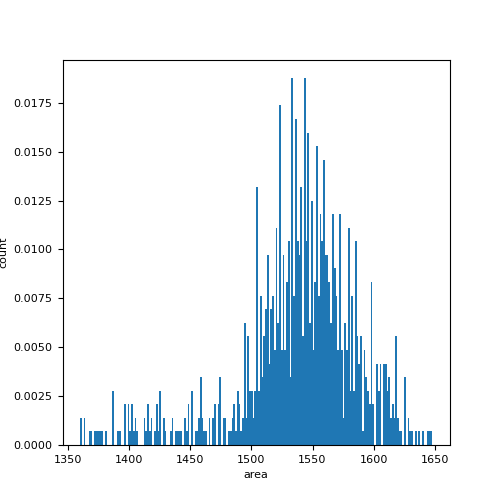

In [214]:
area, x, y, prob = [], [], [], []
for frame in tqdm(range(20)):
    labels_test, dict_test = model.predict_instances(data_preload[frame], prob_thresh=0.9, predict_kwargs = {'verbose':False})
    test = skimage.measure.regionprops_table(labels_test, properties=('centroid', 'area'))
    area += list(test['area'])
    x += list(test['centroid-0'])
    y += list(test['centroid-1'])
    prob += list(dict_test['prob'])

df = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob})
#display(df)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(df['area'], bins=200, density=True)
ax.set(xlabel='area', ylabel='count')
plt.show()

In [215]:
def compute_centroid_and_area(points_array):
    centroid_x_list = []
    centroid_y_list = []
    area_list = []
    
    for points in points_array:
        x = points[0]
        y = points[1]
        
        # Calculate the signed area using the shoelace formula
        area = 0.5 * np.sum(x[:-1] * y[1:] - x[1:] * y[:-1])
        
        # Calculate centroid coordinates
        Cx = np.sum((x[:-1] + x[1:]) * (x[:-1] * y[1:] - x[1:] * y[:-1]))
        Cy = np.sum((y[:-1] + y[1:]) * (x[:-1] * y[1:] - x[1:] * y[:-1]))
        
        # Normalize centroid coordinates and area
        Cx /= (6 * area)
        Cy /= (6 * area)
        area /= 2.0
        
        centroid_x_list.append(Cx)
        centroid_y_list.append(Cy)
        area_list.append(abs(area))
    
    return centroid_x_list, centroid_y_list, area_list

100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


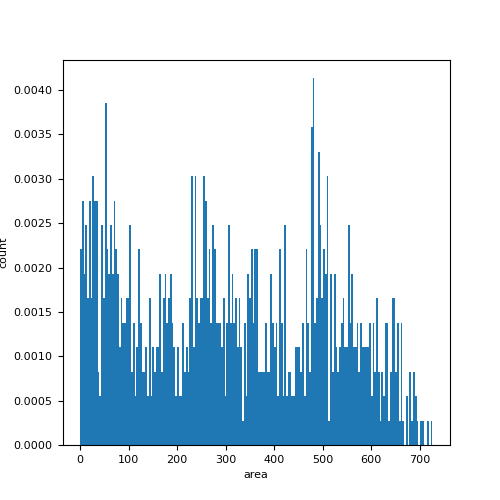

In [216]:
area, x, y, prob = [], [], [], []
for frame in tqdm(range(20)):
    _, dict_test = model.predict_instances(data_preload[frame], prob_thresh=0.9, predict_kwargs = {'verbose':False}, return_labels=False)
    # compute centroids and areas
    cx, cy, a = compute_centroid_and_area(dict_test['coord'])
    area += a
    x += cx
    y += cy
    prob += list(dict_test['prob'])
# set dataframe 
df2 = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob})
#display(df2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(df2['area'], bins=200, density=True)
ax.set(xlabel='area', ylabel='count')
plt.show()

In [ ]:
features = []
for num in tqdm(range(500)):
    for region in skimage.measure.regionprops(label_image[num], intensity_image=data[num]):
        # Store features 
        features.append([{'y': region.centroid[0],
                          'x': region.centroid[1],
                          'frame': num,
                          'area': region.area,
                          },])
features_df = pd.DataFrame([feature[0] for feature in features])
display(features_df)
tp.annotate(features_df[features_df.frame==(0)], data[0])

In [257]:
segm_preload = np.zeros((1000, 960, 920), dtype=np.int8)
for i in tqdm(range(1000)):
    segm_preload[i] = stardist_segm(data[i])
save_path = './data/trial.npz'
# Save the labeled elements using numpy.savez_compressed
np.savez_compressed(save_path, labeled_elements=segm_preload)

  0%|          | 0/1000 [00:00<?, ?it/s]deprecated pixel format used, make sure you did set range correctly
 (repeated 24 more times)
deprecated pixel format used, make sure you did set range correctly
  1%|          | 11/1000 [00:26<39:30,  2.40s/it]


KeyboardInterrupt: 

In [249]:
save_path = './data/trial.npz'
# Save the labeled elements using numpy.savez_compressed
np.savez_compressed(save_path, labeled_elements=segm_preload)

In [250]:
loaded_data = np.load(save_path)

# Access the labeled elements array
labeled_elements = loaded_data['labeled_elements']

In [255]:
np.where(labeled_elements-segm_preload !=0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

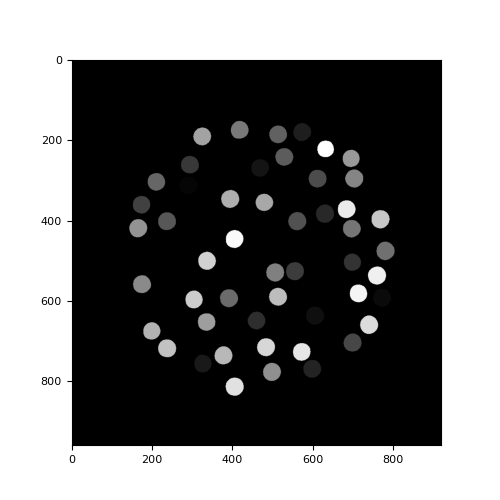

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(labeled_elements[0], cmap='gray')
plt.show()

In [246]:
import skimage.io as io
io.find_available_plugins()
io.imsave('./data/movie2.tif', segm_preload)

2461978930.py (3): ./data/movie2.tif is a low contrast image


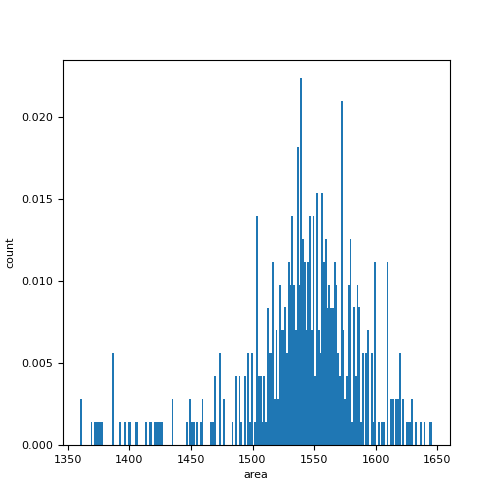

In [227]:
area, x, y, prob = [], [], [], []
for labels_test in segm_preload:
    #labels_test, dict_test = model.predict_instances(data_preload[frame], prob_thresh=0.9, predict_kwargs = {'verbose':False})
    test = skimage.measure.regionprops_table(labels_test, properties=('centroid', 'area'))
    area += list(test['area'])
    x += list(test['centroid-0'])
    y += list(test['centroid-1'])
    prob += list(dict_test['prob'])

df = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob})
df.to_parquet('./data/df.parquet')
#display(df)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(df['area'], bins=200, density=True)
ax.set(xlabel='area', ylabel='count')
plt.show()

In [3]:
save_path = './data/trial.npz'
loaded_data = np.load(save_path)
# Access the labeled elements array
labeled_elements = loaded_data['labeled_elements']
print("Size of the array: ",
      labeled_elements.size)
 
print("Memory size of one array element in bytes: ",
      labeled_elements.itemsize)
 
# memory size of numpy array in bytes
print("Memory size of numpy array in bytes:",
      labeled_elements.size * labeled_elements.itemsize)

#print(np.where(labeled_elements-segm_preload !=0))

Size of the array:  883200000
Memory size of one array element in bytes:  8
Memory size of numpy array in bytes: 7065600000


In [13]:
labels_test, dict_test = model.predict_instances(data_preload[0], prob_thresh=0.9, predict_kwargs = {'verbose':False})

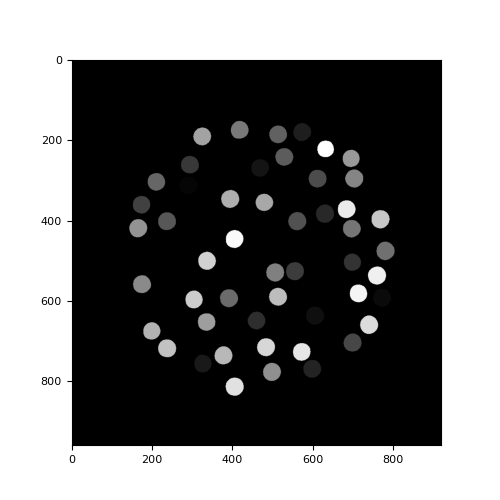

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))    
ax.imshow(labels_test)
plt.show()

In [23]:
labels_test.shape

(960, 920)

In [25]:
np.max(labels_test), np.min(labels_test)

(50, 0)

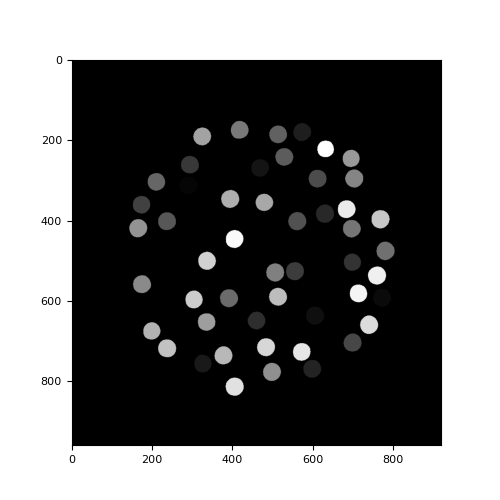

TypeError: Non-integer label_image types are ambiguous

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(labeled_elements[0], cmap='gray')
plt.show()

area, x, y, prob = [], [], [], []
for labels_test in labeled_elements:
    #labels_test, dict_test = model.predict_instances(data_preload[frame], prob_thresh=0.9, predict_kwargs = {'verbose':False})
    test = skimage.measure.regionprops_table(labels_test, properties=('centroid', 'area'))
    area += list(test['area'])
    x += list(test['centroid-0'])
    y += list(test['centroid-1'])
    prob += list(dict_test['prob'])

df = pd.DataFrame({'x':x, 'y':y, 'area':area, 'prob':prob})
df.to_parquet('./data/df.parquet')
print(df)

In [ ]:



fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(df['area'], bins=200, density=True)
ax.set(xlabel='area', ylabel='count')
plt.show()

fig = plt.figure(figsize = (8, 8))
def update_graph(frame):
    graph2.set_data(labeled_elements[frame])
    title.set_text('Stardist location - frame = {}'.format(frame))
    return graph2

ax = fig.add_subplot(111)
title = ax.set_title('Stardist location - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
graph2 = ax.imshow(labeled_elements[0])

ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(0, 1000, 1), interval = 50, blit=False)
#writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
#ani.save('./results/video2.mp4', writer=writer, dpi = 300)
plt.show()